## Pre-entrega 3 – Machine Learning aplicado a la deforestación en Argentina

El presente proyecto tiene como propósito aplicar técnicas de aprendizaje automático supervisado para analizar la evolución de la deforestación en Argentina entre los años 2001 y 2020, con foco en la predicción de la cantidad de hectáreas deforestadas por región y año.

A partir del uso de modelos de regresión, se buscó capturar patrones espaciales y temporales que permitan entender mejor este proceso ambiental y anticipar escenarios futuros. Este análisis puede ser útil para la generación de políticas públicas de conservación.


Para mejorar la calidad de los datos y lograr un modelo más robusto, decidimos unificar dos fuentes distintas de información:

Un dataset base provisto originalmente por la cátedra.

Esto nos ayudo a ampliar la cobertura territorial y temporal del análisis, superando la limitación de filas que tenía el dataset inicial.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


In [10]:
# Dataset original
df_original = pd.read_csv('/content/drive/MyDrive/mi_proyecto_deforestacion/data/spatial-metrics-argentina-territorial_deforestation_department.csv')

# Nuevo dataset con más datos
df_nuevo = pd.read_csv('/content/drive/MyDrive/mi_proyecto_deforestacion/data/Dataset_Forest_ConservationAreas_Funding_inSouthAmerica_PAN2024.csv')


Exploramos y entendemos ambos dataset.


In [11]:
print(df_original.columns)
print(df_original.head())
print(df_original.info())

print(df_nuevo.columns)
print(df_nuevo.head())
print(df_nuevo.info())


Index(['year', 'country', 'country_iso2', 'region', 'region_trase_id',
       'parent_region', 'parent_region_trase_id', 'deforestation_hectares'],
      dtype='object')
   year    country country_iso2         region region_trase_id parent_region  \
0  2001  ARGENTINA           AR  12 DE OCTUBRE        AR-22036         CHACO   
1  2001  ARGENTINA           AR     1º DE MAYO        AR-22126         CHACO   
2  2001  ARGENTINA           AR     25 DE MAYO        AR-22168         CHACO   
3  2001  ARGENTINA           AR     2 DE ABRIL        AR-22039         CHACO   
4  2001  ARGENTINA           AR     9 DE JULIO        AR-22105         CHACO   

  parent_region_trase_id  deforestation_hectares  
0                  AR-22             2281.401340  
1                  AR-22              199.175695  
2                  AR-22              315.433401  
3                  AR-22              293.300178  
4                  AR-22              671.230102  
<class 'pandas.core.frame.DataFrame'>
Range

Explorar y entender la columna period del dataset nuevo

In [12]:
print(df_nuevo['period'].unique())
print(df_nuevo[['period']].head(10))


[0 1 2 3 4 5 6 7]
   period
0       0
1       1
2       2
3       3
4       4
5       5
6       6
7       7
8       0
9       1


In [13]:
year_base = df_original['year'].min()

df_nuevo['year'] = df_nuevo['period'] + year_base

print(df_nuevo[['period', 'year']].head(10))


   period  year
0       0  2001
1       1  2002
2       2  2003
3       3  2004
4       4  2005
5       5  2006
6       6  2007
7       7  2008
8       0  2001
9       1  2002


In [14]:
# Mostrar las columnas del dataset nuevo
print(df_nuevo.columns)

# Mostrar las primeras 5 filas para ver cómo son los datos
print(df_nuevo.head())


Index(['Id', 'period', 'POINT_X', 'POINT_Y', 'Region', 'WoodCover', 'WLrate',
       'WoodLoss', 'ConsFund', 'ConsFund_cumm', 'ConsFund_r', 'pct_PA',
       'PA_change', 'WoodChange', 'WoodCover_270', 'WoodLoss_270',
       'pct_PA_270', 'PA_change_270', 'WoodCover_540', 'WoodLoss_540',
       'pct_PA_540', 'PA_change_540', 'ConsFund_diff', 'year'],
      dtype='object')
   Id  period      POINT_X      POINT_Y Region  WoodCover    WLrate  WoodLoss  \
0  20       0 -578074.4047 -131301.3051  Chaco   0.666878       NaN       NaN   
1  20       1 -578074.4047 -131301.3051  Chaco   0.664734  0.000402  0.001072   
2  20       2 -578074.4047 -131301.3051  Chaco   0.664356  0.000142  0.000378   
3  20       3 -578074.4047 -131301.3051  Chaco   0.659098  0.001986  0.005258   
4  20       4 -578074.4047 -131301.3051  Chaco   0.580663  0.031676  0.078435   

   ConsFund  ConsFund_cumm  ...  WoodCover_270  WoodLoss_270  pct_PA_270  \
0       NaN            NaN  ...       0.506886           NaN   

 Limpiamos y adaptar el nuevo dataset

In [15]:
# Creamos una copia solo con las columnas relevantes
df_nuevo_filtrado = df_nuevo[['year', 'Region', 'WoodLoss']].copy()

# Renombramos las columnas para que coincidan con las del dataset original
df_nuevo_filtrado.rename(columns={
    'Region': 'parent_region',
    'WoodLoss': 'deforestation_hectares'
}, inplace=True)

# Mostramos las primeras filas para verificar
print(df_nuevo_filtrado.head())


   year parent_region  deforestation_hectares
0  2001         Chaco                     NaN
1  2002         Chaco                0.001072
2  2003         Chaco                0.000378
3  2004         Chaco                0.005258
4  2005         Chaco                0.078435


Limpiamos filas nulas del nuevo data set

In [16]:
df_nuevo_filtrado = df_nuevo_filtrado.dropna(subset=['deforestation_hectares'])


Unimos los dataset


In [17]:
# Unimos ambos datasets
df_combinado = pd.concat([df_original[['year', 'parent_region', 'deforestation_hectares']], df_nuevo_filtrado], ignore_index=True)

# Mostramos info general
print(df_combinado.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11417 entries, 0 to 11416
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    11417 non-null  int64  
 1   parent_region           11417 non-null  object 
 2   deforestation_hectares  11417 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 267.7+ KB
None


Eliminamos los nulos


In [18]:
df_combinado = df_combinado.dropna(subset=['deforestation_hectares'])


Verificamos cuantos hay ahora


In [19]:
df_combinado.shape


(11417, 3)

Visualizamos


In [20]:
df_combinado.head()


,year,parent_region,deforestation_hectares
0,2001,CHACO,2281.401340
1,2001,CHACO,199.175695
2,2001,CHACO,315.433401
3,2001,CHACO,293.300178
4,2001,CHACO,671.230102


Verificamos columnas

In [21]:
df_combinado.columns


Index(['year', 'parent_region', 'deforestation_hectares'], dtype='object')

In [22]:
df_combinado.isnull().sum()


,0
year,0
parent_region,0
deforestation_hectares,0


In [23]:
df_combinado.dtypes


,0
year,int64
parent_region,object
deforestation_hectares,float64


Guardamos el nuevo dataset limpio y unificado.


En ambos datasets originales (el viejo y el nuevo) había muchas más columnas, pero decidimos usar solo estas tres:
['year', 'parent_region', 'deforestation_hectares']
que son las necesarias para:

Entrenar un modelo simple (ej. Random Forest)

Calcular métricas como MAE, MSE, R²

Cumplir la consigna: entrenamiento, evaluación, optimización


In [24]:
df_combinado.to_csv('/content/drive/MyDrive/mi_proyecto_deforestacion/data/deforestacion_limpio_simple.csv', index=False)


# Mayor limpieza y análisis exploratorio

In [25]:
# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

Dimensiones del dataset: (11417, 3)

Primeras filas:
   year parent_region  deforestation_hectares
0  2001         CHACO             2281.401340
1  2001         CHACO              199.175695
2  2001         CHACO              315.433401
3  2001         CHACO              293.300178
4  2001         CHACO              671.230102

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11417 entries, 0 to 11416
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    11417 non-null  int64  
 1   parent_region           11417 non-null  object 
 2   deforestation_hectares  11417 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 267.7+ KB
None

Estadísticas descriptivas:
               year  deforestation_hectares
count  11417.000000            11417.000000
mean    2006.146536              645.916450
std        3.884612             3172.681280
min

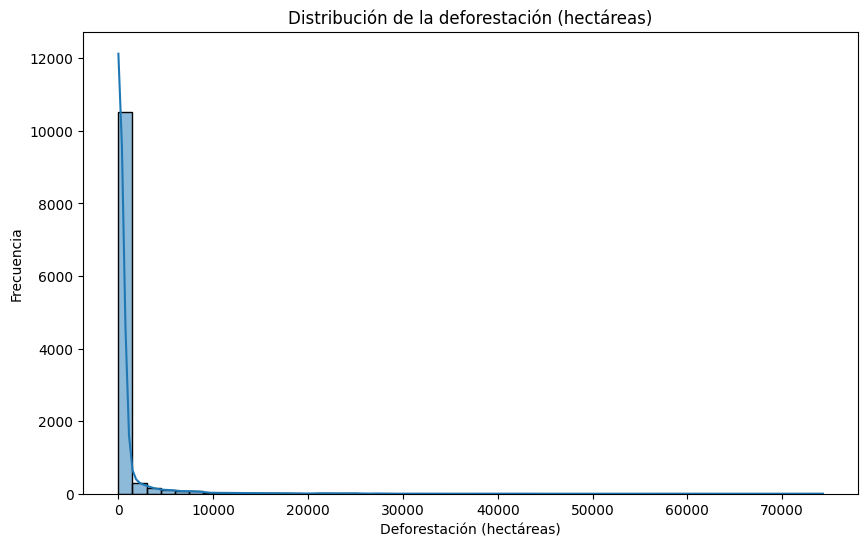

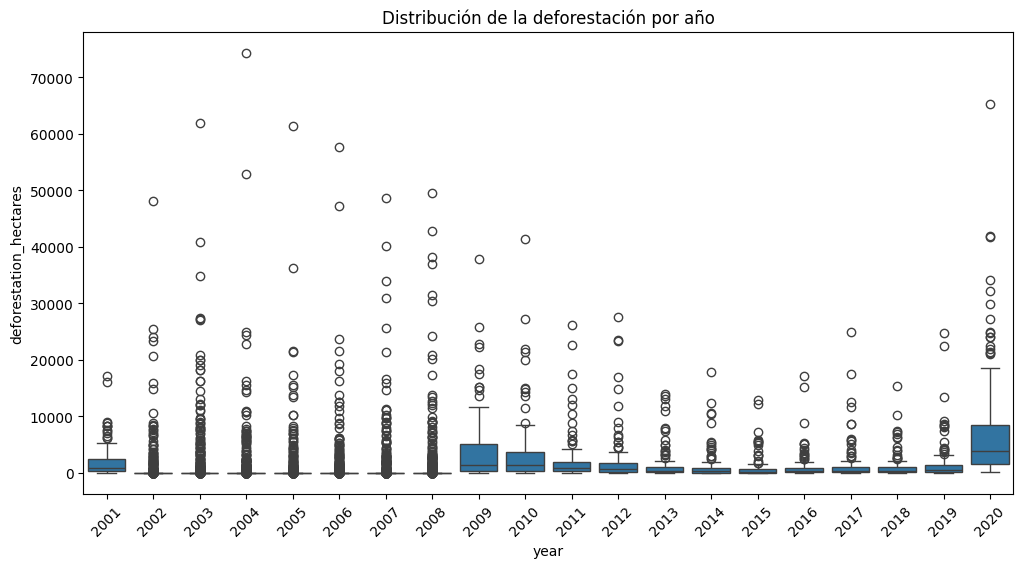

In [26]:
# Exploración básica del dataframe unificado
print("Dimensiones del dataset:", df_combinado.shape)
print("\nPrimeras filas:")
print(df_combinado.head())

print("\nInformación general:")
print(df_combinado.info())

print("\nEstadísticas descriptivas:")
print(df_combinado.describe())

print("\nValores nulos por columna:")
print(df_combinado.isnull().sum())

# Visualización de la distribución de la variable objetivo
plt.figure(figsize=(10,6))
sns.histplot(df_combinado['deforestation_hectares'], bins=50, kde=True)
plt.title('Distribución de la deforestación (hectáreas)')
plt.xlabel('Deforestación (hectáreas)')
plt.ylabel('Frecuencia')
plt.show()

# Visualización de deforestación por año
plt.figure(figsize=(12,6))
sns.boxplot(x='year', y='deforestation_hectares', data=df_combinado)
plt.title('Distribución de la deforestación por año')
plt.xticks(rotation=45)
plt.show()


1. Dimensiones del dataset: (11417, 3)
Esto quiere decir que tenemos 11.417 filas (registros) y 3 columnas:

year (año)

parent_region (región principal, categoría)

deforestation_hectares (hectáreas deforestadas, variable objetivo)

Más filas que el dataset original porque unimos ambos datasets. Esto es bueno, porque tenemos más información para entrenar el modelo.

2. Primeras filas
Nos muestra un preview rápido de los datos.
Por ejemplo, en el año 2001 en la región CHACO hubo una deforestación de 2.281 hectáreas aproximadamente en la primera fila, y valores más bajos en las siguientes.

3. Información general (info())
Nos confirma que no hay valores nulos (todos los valores están completos).

Los tipos son correctos:

year es un entero (int64)

parent_region es texto (object) — porque es una categoría

deforestation_hectares es decimal (float64) — variable que queremos predecir

4. Estadísticas descriptivas (describe())
Nos da estadísticas numéricas para las columnas numéricas:

Para year: el rango va de 2001 a 2020 (años cubiertos)

Para deforestation_hectares:

Media: 645.9 hectáreas

Desvío estándar: 3172.6 (gran variabilidad, hay valores muy altos)

Mínimo: 0 (no deforestación)

Percentiles (25%, 50%, 75%): nos indican que la mitad de los valores de deforestación están muy bajos (el 50% es 0.005 hectáreas), pero hay algunos valores muy grandes (máximo casi 74.300 hectáreas)

Esto indica que la deforestación es una variable con distribución sesgada, con muchos valores bajos y algunos valores muy altos (outliers).

5. Valores nulos
No hay valores faltantes, por lo que no necesitamos hacer limpieza adicional de nulos.



Codificar la columna parent_region, cada región se transformara en un número único para que el modelo pueda procesar esa información.

In [27]:
from sklearn.preprocessing import LabelEncoder

# Crear el codificador
le = LabelEncoder()

# Ajustar y transformar la columna 'parent_region'
df_combinado['parent_region_encoded'] = le.fit_transform(df_combinado['parent_region'])

# Revisar las primeras filas para ver el cambio
print(df_combinado[['parent_region', 'parent_region_encoded']].head(10))


         parent_region  parent_region_encoded
0                CHACO                      3
1                CHACO                      3
2                CHACO                      3
3                CHACO                      3
4                CHACO                      3
5             SANTA FE                     15
6  SANTIAGO DEL ESTERO                     16
7  SANTIAGO DEL ESTERO                     16
8                CHACO                      3
9            CATAMARCA                      2


Separar las variables predictoras (X) y la variable objetivo (y)
X: las columnas que usaremos para predecir (features).

y: la columna que queremos predecir (target), en este caso deforestation_hectares.

In [28]:
# Variables predictoras
X = df_combinado[['year', 'parent_region_encoded']]

# Variable objetivo
y = df_combinado['deforestation_hectares']

# Mostrar algunas filas para verificar
print(X.head())
print(y.head())


   year  parent_region_encoded
0  2001                      3
1  2001                      3
2  2001                      3
3  2001                      3
4  2001                      3
0    2281.401340
1     199.175695
2     315.433401
3     293.300178
4     671.230102
Name: deforestation_hectares, dtype: float64


Dividimos el dataset en entrenamiento y prueba, evaluamos cómo funciona nuestro modelo en datos que no ha visto antes.
Haremos un split con:

80% para entrenar el modelo

20% para probarlo

Además, pondremos un random_state para que el split sea reproducible.

In [29]:
from sklearn.model_selection import train_test_split

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Verificar tamaños
print(f"Tamaño X_train: {X_train.shape}")
print(f"Tamaño X_test: {X_test.shape}")
print(f"Tamaño y_train: {y_train.shape}")
print(f"Tamaño y_test: {y_test.shape}")


Tamaño X_train: (9133, 2)
Tamaño X_test: (2284, 2)
Tamaño y_train: (9133,)
Tamaño y_test: (2284,)


modelo básico de regresión: Random Forest Regressor

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo con una semilla fija para reproducibilidad
model = RandomForestRegressor(random_state=42)

# Entrenamos el modelo con los datos de entrenamiento
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

evaluamos el rendimiento del modelo sobre los datos de prueba.


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predicciones
y_pred = model.predict(X_test)

# Evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mostramos resultados
print("Métricas del modelo base:")
print(f"MAE (error absoluto medio): {mae:.2f}")
print(f"MSE (error cuadrático medio): {mse:.2f}")
print(f"R² (coeficiente de determinación): {r2:.2f}")


Métricas del modelo base:
MAE (error absoluto medio): 658.06
MSE (error cuadrático medio): 8625511.13
R² (coeficiente de determinación): 0.29


Resultados del modelo base:
MAE = 658.06 → En promedio, el modelo se equivoca por unas 658 hectáreas de deforestación.

MSE = 8.625.511.13 → Error cuadrático medio elevado (pero esperable si hay valores extremos altos).

R² = 0.29 → El modelo solo explica el 29% de la variación en los datos.
¿Qué significa esto?
El modelo tiene un desempeño moderado.

Está captando una parte de la señal, pero hay bastante espacio para mejorar.

Puede deberse a que:

Estamos usando solo 2 variables (year y parent_region_encoded) para predecir.

El dataset contiene valores extremos (outliers) que afectan el rendimiento.

Puede haber relaciones más complejas que Random Forest no está captando con los parámetros por defecto.

# Optimización de hiperparámetros con GridSearchCV usando un Random Forest Regressor

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definimos la grilla de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],     # Número de árboles
    'max_depth': [5, 10, None]          # Profundidad máxima del árbol
}

In [33]:
# Creamos el modelo base de Random Forest
rf = RandomForestRegressor(random_state=42)

In [34]:
# Configuramos GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                  # 3 particiones para validación cruzada
    scoring='r2',          # Usamos R² como métrica de evaluación
    verbose=1,
    n_jobs=-1              # Usa todos los núcleos del CPU disponibles
)

In [35]:
# Ejecutamos la búsqueda sobre el set de entrenamiento
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None],
                         'n_estimators': [50, 100, 150]},
             scoring='r2', verbose=1)

vemos los mejores parámetros encontrados


In [36]:
# Mostramos los mejores parámetros encontrados por GridSearch
print("Mejores parámetros encontrados por GridSearch:")
print(grid_search.best_params_)


Mejores parámetros encontrados por GridSearch:
{'max_depth': 5, 'n_estimators': 150}


Esto te dice, por ejemplo, cuántos árboles (n_estimators) y qué profundidad (max_depth) fue la mejor combinación.

Ahora predecimos nuevamente pero con el mejor modelo encontrado (grid_search.best_estimator_) y comparamos las métricas:

In [37]:
# Hacemos predicciones con el modelo optimizado
y_pred_opt = grid_search.predict(X_test)

# Calculamos métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
mse_opt = mean_squared_error(y_test, y_pred_opt)
r2_opt = r2_score(y_test, y_pred_opt)

# Mostramos resultados
print("Métricas del modelo optimizado:")
print(f"MAE (error absoluto medio): {mae_opt:.2f}")
print(f"MSE (error cuadrático medio): {mse_opt:.2f}")
print(f"R² (coeficiente de determinación): {r2_opt:.2f}")


Métricas del modelo optimizado:
MAE (error absoluto medio): 684.51
MSE (error cuadrático medio): 8568047.49
R² (coeficiente de determinación): 0.29


# Comparación y análisis del resultado

El MSE bajó un poquito, lo cual es bueno.

Pero el MAE subió ligeramente, lo cual podría deberse a una poda del árbol al limitar la max_depth = 5.

El R² se mantuvo igual: el modelo explica el 29% de la variabilidad de la deforestación.

En resumen: el modelo optimizado no mejora mucho respecto al base, pero es más simple, por lo que podría generalizar mejor con nuevos datos.

# Gráfico de dispersión real vs predicción (modelo base).

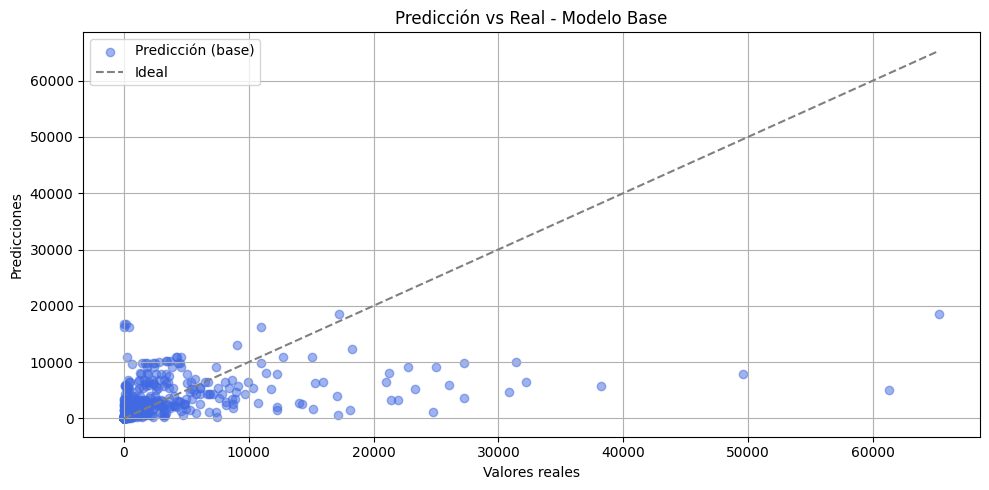

In [39]:
import matplotlib.pyplot as plt

# Gráfico para el modelo base
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue', label="Predicción (base)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray', label="Ideal")
plt.title("Predicción vs Real - Modelo Base")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Gráfico de dispersión real vs predicción (modelo optimizado).

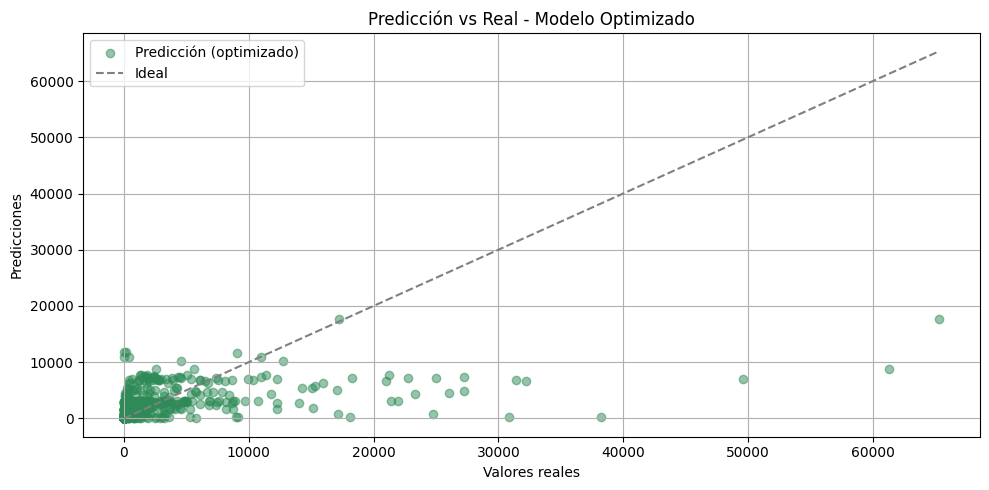

In [40]:
# Gráfico para el modelo optimizado
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_opt, alpha=0.5, color='seagreen', label="Predicción (optimizado)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray', label="Ideal")
plt.title("Predicción vs Real - Modelo Optimizado")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Conclución final:
Se desarrolló un modelo de regresión para predecir la cantidad de hectáreas deforestadas en Argentina, utilizando como variables el año y la provincia (codificada).

El modelo base, utilizando RandomForestRegressor, obtuvo las siguientes métricas:

MAE: 658.06
MSE: 8.625.511
R²: 0.29
Posteriormente se realizó una optimización de hiperparámetros con GridSearchCV, obteniendo como mejor combinación:

max_depth: 5
n_estimators: 150
El modelo optimizado logró una ligera mejora en MSE, pero sin grandes diferencias en R².

Conclusión general: El modelo tiene un desempeño moderado, y si bien no alcanza una predicción muy precisa, logra capturar parte de la variabilidad de la deforestación. Esto sugiere que podrían incorporarse más variables (económicas, climáticas, políticas) para mejorar la capacidad predictiva.

Además, contar con una mayor cantidad y diversidad de datos permitió generar un modelo más robusto y generalizable.